In [1]:
Threads.nthreads()

1

In [2]:
using NNGCM
using LinearAlgebra
using Random
using Distributions
using JLD2
include("Barotropic.jl")
include("../../Inversion/Plot.jl")
include("../../Inversion/KalmanInversion.jl")

solve_β (generic function with 2 methods)

# Barotropic flow


The barotropic vorticity equation describes the evolution of a non-divergent, incompressible flow on the surface of the earth:

$$
\begin{align*}
        &\frac{\partial \omega}{\partial t} = - v \cdot \nabla (\omega + f), \\
        &\nabla^2\psi = \omega \qquad v = k \times \nabla\psi,
\end{align*}
$$

where $\omega$ and $\psi$ are vorticity and streamfunction, respectively. $v$ is the non-divergent flow velocity, $k$ is the unit vector in the radial direction, and $f = 2\Omega \sin(\phi)$ is the Coriolis force, depending on the latitude $\phi$. The angular velocity is $\Omega = 7.292\times10^5 s^{-1}$.


# Spherical coordinates 


Longitude $\lambda$ ranges from $0$ to $2\pi$, and latitude $\phi$ from $−\pi/2$ at the South Pole to $\pi/2$ at the North Pole. The transformation is 

$$
\begin{align*}
x &= r \cos \lambda \cos \phi \\
y &= r \sin \lambda \cos \phi \\
z &= r \sin \phi
\end{align*}
$$

Let $v_{\lambda}$ be the zonal (eastward) velocity and $v_{\phi}$ be the northward velocity at constant radius.
The velocity becomes 
$$v =  v_{\lambda} e_{\lambda} + v_{\phi}e_{\phi} \qquad e_{\lambda} = (- \sin \lambda,\, \cos \lambda,\,  0)\quad  e_{\phi} = (-\cos \lambda \sin \phi, \, -\sin \lambda \sin \phi, \, \cos \phi) $$


The divergence operator and the radial component of the vorticity operator on the sphere are 
$$
\begin{align*}
\nabla v = \frac{1}{R\cos \phi} \frac{\partial v_{\lambda}}{\partial \lambda} + \frac{1}{R\cos \phi} \frac{\partial }{\partial \phi} \Big(v_{\phi} \cos \phi \Big)\\
\nabla \times v = \frac{1}{R\cos \phi} \frac{\partial v_{\phi}}{\partial \lambda} - \frac{1}{R\cos \phi} \frac{\partial }{\partial \phi} \Big(v_{\lambda} \cos \phi \Big)
\end{align*}
$$
here $v$ can be an arbitrary vector field on the sphere.

The flow filed can be reconstitued from the streamfunction $\psi$ as 

$$v_{\lambda} = -\frac{1}{R}\frac{\partial \psi}{\partial \phi} \qquad v_{\psi} = \frac{1}{R\cos\phi}\frac{\partial \psi}{\partial \lambda}$$

The barotropic vorticity equation can be rewritten as 

$$
\begin{align*}
        \frac{\partial \omega}{\partial t} &= -  \nabla v(\omega + f) \\
                                           &= -  \frac{1}{R\cos \phi} \frac{\partial v_{\lambda}(\omega + f)}{\partial \lambda} - \frac{1}{R\cos \phi} \frac{\partial }{\partial \phi} \Big(v_{\phi}(\omega + f) \cos \phi \Big)\\
                                           &= -  \frac{ v_{\lambda}}{R\cos \phi} \frac{\partial(\omega + f)}{\partial \lambda} - \frac{v_{\phi}}{R} \frac{\partial (\omega + f)}{\partial \phi}\\
                                           &= \frac{ 1}{R^2\cos \phi} \Big[\frac{\partial \psi}{\partial \phi}\frac{\partial(\omega + f)}{\partial \lambda} - \frac{\partial \psi}{\partial \lambda}\frac{\partial (\omega + f)}{\partial \phi}\Big]\\
\end{align*}
$$

We use the Earth radius $R = 6.3712\times10^6~m$.

## Random log-Gaussian Field

Assuming that $\log a(x, \theta)$ is a centred Gaussian with covariance 
$$\mathsf{C} = (-\Delta + \tau^2 )^{-d};$$
here $-\Delta$ denotes the Laplacian on $D$ subject to homogeneous Neumann boundary conditions on the space of spatial-mean zero functions, 
$\tau > 0$ denotes the inverse length scale of the random field and $d  > 0$ determines its regularity.
The Gaussian field can be represented by the Karhunen–Loève (KL) expansion

\begin{equation}
\label{eq:KL-2d}
    \log a(x,\theta) = \sum_{l\in K} \theta_{(l)}\sqrt{\lambda_l} \psi_l(x),
\end{equation}
where $K = \mathcal{Z}^{0+}\times\mathcal{Z}^{0+} \setminus \{0,0\}$, and the eigenpairs are of the form

$$
\begin{equation*}
    \psi_l(x) = \begin{cases}
                 \sqrt{2}\cos(\pi l_1 x_1)              & l_2 = 0\\
                 \sqrt{2}\cos(\pi l_2 x_2)              & l_1 = 0\\
                 2\cos(\pi l_1 x_1)\cos(\pi l_2 x_2)    & \textrm{otherwise}\\
                 \end{cases},
                 \qquad \lambda_l = (\pi^2 |l|^2 + \tau^2)^{-d}
\end{equation*}
$$

and $\theta_{(l)} \sim \mathcal{N}(0,1)$ i.i.d. The KL expansion can be rewritten as a sum over $\mathcal{Z}^{0+}$ rather than a lattice: 

$$
\begin{equation}
\label{eq:KL-1d}
    \log a(x,\theta) = \sum_{k\in \mathcal{Z}^{0+}} \theta_{(k)}\sqrt{\lambda_k} \psi_k(x),
\end{equation}
$$

where the eigenvalues $\lambda_k$ are in descending order.
In practice, we truncate this sum to $N_\theta$ terms, based on the
largest $N_\theta$ eigenvalues, and hence $\theta\in\mathcal{R}^{N_\theta}$.
 


## Inverse Problem Setup

For the inverse problem, we recover the log-permeability field $\log a_{{ref}}(x)$ from the observation 
$y_{ref}$, which consists of pointwise measurements of the 
pressure value $p(x)$ at $49$ equidistant points in the domain. 


We generate a truth random field $\log a_{{ref}}(x)$ with $\theta \sim \mathcal{N}(0, I)$ in $\mathcal{R}^{256}$ 
(i.e. we use the first $256$ KL modes) to construct the observation $y_{obs}$.

$5\%$ Gaussian random noises are added to make data $y_{obs}$:

$$
\begin{equation}
    y_{obs} = y_{ref} + \epsilon \odot  \mathcal{N}(0, I),
\end{equation}
$$

where $\epsilon = 5\% y_{ref}$, and $\odot$ denotes element-wise multiplication.



In [3]:
num_fourier, nθ =  42, 64 # 85, 128  #
Δt, end_time =  1800, 86400
n_obs_frames = 2
obs_time, nobs = Int64(end_time/n_obs_frames), 100
antisymmetric = false
trunc_N = 12
N_θ = (trunc_N+2)*trunc_N
N_y = nobs*n_obs_frames + N_θ 
barotropic = Setup_Param(num_fourier, nθ, Δt, end_time, n_obs_frames, nobs, antisymmetric, N_y, trunc_N);



## Inverse Problem Setup

Using this data, we consider an incomplete parameterization scenarios:  
* solving for the first $63$ spherical modes ($N_r=7$) 
        
        
GMKI is applied and initialized with $\theta_0 \sim \mathcal{N}(0,  I)$. 
The observation error is estimated to be $\eta \sim \mathcal{N}(0, I)$. 



In [4]:
# Generate reference observation
mesh, obs_raw_data = Barotropic_Main(barotropic, nothing; init_type = "truth");
# mesh, obs_raw_data = Barotropic_Main(barotropic, barotropic.init_data; init_type = "spec_vor");

In [5]:
# Plot observation data
obs_coord = barotropic.obs_coord
n_obs_frames = barotropic.n_obs_frames
antisymmetric = barotropic.antisymmetric
for i_obs = 1:n_obs_frames
    Lat_Lon_Pcolormesh(mesh, obs_raw_data["vel_u"][i_obs], 1, obs_coord; save_file_name =   "Figs/Barotropic_u-"*string(i_obs)*".pdf", cmap = "viridis", antisymmetric=antisymmetric)
    Lat_Lon_Pcolormesh(mesh, obs_raw_data["vor"][i_obs], 1, obs_coord; save_file_name =   "Figs/Barotropic_vor-"*string(i_obs)*".pdf", cmap = "viridis", antisymmetric=antisymmetric)

end     


┌ Info: ("observation error = ", 1.6188761397227893e-19)
└ @ Main In[6]:18


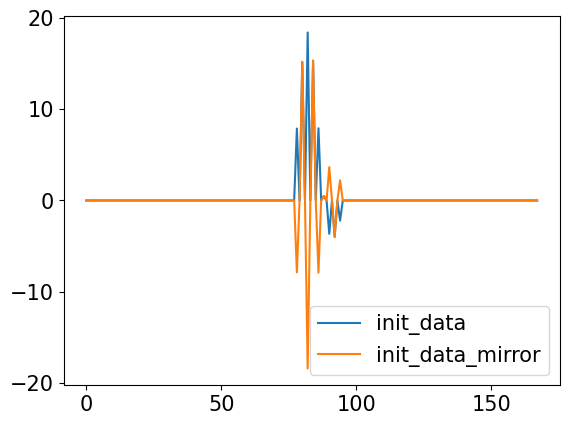

In [6]:
# Check the mirror solution
grid_vor_mirror = -barotropic.grid_vor[:, end:-1:1,  :]
spe_vor_mirror = similar(barotropic.spe_vor_b)
Trans_Grid_To_Spherical!(mesh, grid_vor_mirror, spe_vor_mirror)
    
mesh, obs_raw_data_mirror = Barotropic_Main(barotropic, grid_vor_mirror; init_type = "grid_vor");
for i_obs = 1:n_obs_frames
    Lat_Lon_Pcolormesh(mesh, obs_raw_data_mirror["vel_u"][i_obs], 1, obs_coord; save_file_name =   "Figs/Barotropic_u-"*string(i_obs)*"-mirror.pdf", cmap = "viridis", antisymmetric=antisymmetric)
    Lat_Lon_Pcolormesh(mesh, obs_raw_data_mirror["vor"][i_obs], 1, obs_coord; save_file_name =   "Figs/Barotropic_vor-"*string(i_obs)*"-mirror.pdf", cmap = "viridis", antisymmetric=antisymmetric)
end 

Lat_Lon_Pcolormesh(mesh, grid_vor_mirror, 1; save_file_name = "Figs/Barotropic_vor0_mirror.pdf", cmap = "viridis")
init_data_mirror = spe_to_param(spe_vor_mirror-barotropic.spe_vor_b, barotropic.trunc_N; radius=barotropic.radius)

PyPlot.plot(barotropic.init_data, label="init_data")
PyPlot.plot(init_data_mirror, label="init_data_mirror")
PyPlot.legend()
@info "observation error = ", norm(convert_obs(barotropic.obs_coord,obs_raw_data,antisymmetric=true) - convert_obs(barotropic.obs_coord,obs_raw_data_mirror,antisymmetric=true))

# GMKI

In [63]:
@load "ukiobj.jld2" ukiobj

1-element Vector{Symbol}:
 :ukiobj

In [64]:
ukiobj.θ_mean

11-element Vector{Matrix{Float64}}:
 [-4.5489516314188307e-17 2.1621610314942505e-17 … -1.2802337878737035e-16 -1.862155921413959e-17; -4.047462235159949e-14 -3.0388666848921523e-15 … 1.3981151585357143e-16 2.6951049768337848e-17; 10.51517073408185 -0.19594451905412819 … -4.722388640225573 -8.19972812530268]
 [-0.0020897319689281435 0.030939236660205073 … -0.0138150935948323 0.006208219481910989; -0.002350319960285476 0.035332770215524924 … -0.01168420828045072 -0.002388013764307871; -0.7678846403409967 0.5575174422699816 … -6.841523450307694 -7.4912308561715815]
 [-0.0006694739032303779 0.06626291261330108 … -0.036073441316886896 0.02829887197439308; -0.00208925987522067 0.07945198662737193 … -0.026096648153051034 -0.012625625263659054; -1.1733836812481564 1.6041993273900643 … -6.927930780548215 -5.566085949820145]
 [0.0009426476886589975 0.11235237349426891 … -0.0752237499220013 0.08413664110250543; -0.0026035091981398773 0.12568313755376728 … -0.042439083584218086 -0.042940494568889

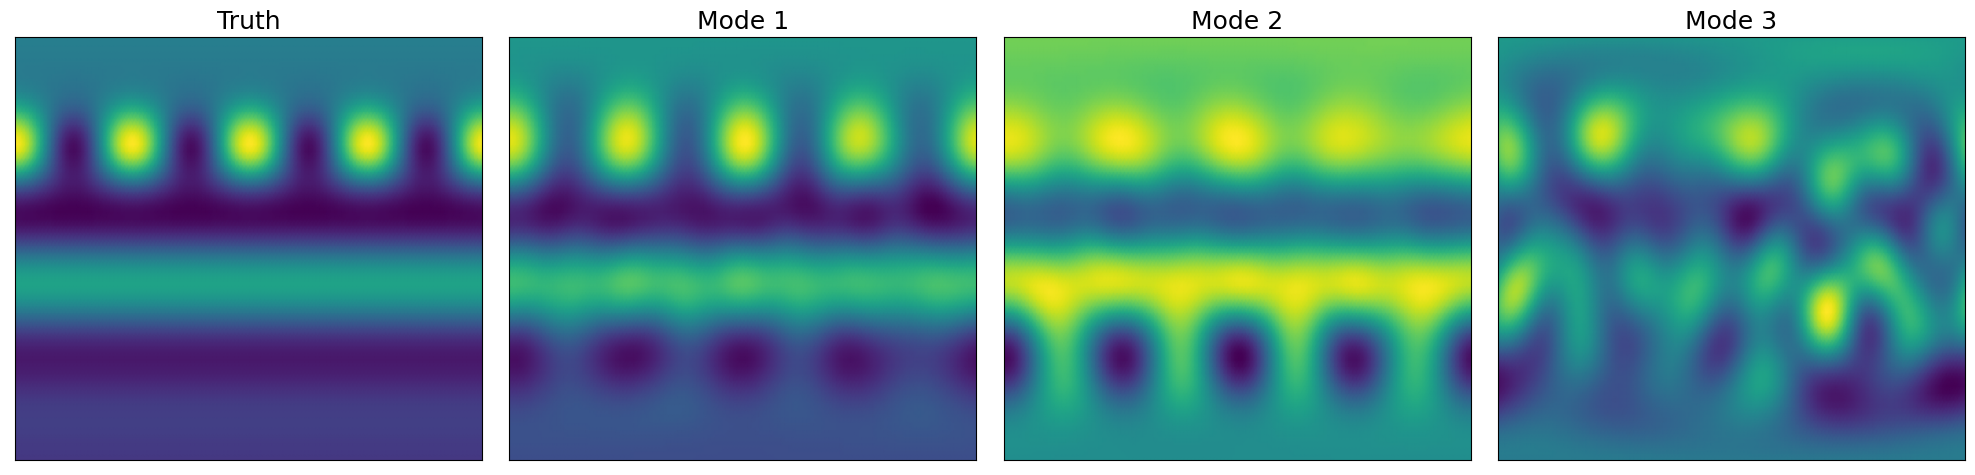

In [75]:
function plot_field(mesh::Spectral_Spherical_Mesh, grid_dat::Array{Float64,3}, level::Int64, clim, ax; cmap="viridis")
    
    λc, θc = mesh.λc, mesh.θc
    nλ, nθ = length(λc), length(θc)
    λc_deg, θc_deg = λc*180/pi, θc*180/pi
    
    X,Y = repeat(λc_deg, 1, nθ), repeat(θc_deg, 1, nλ)'
    
    
    return ax.pcolormesh(X, Y, grid_dat[:,:,level], shading= "gouraud", clim=clim, cmap=cmap)
    
end

N_iter = 8
N_ens = 2N_θ + 1
# visulize the log permeability field
fig_vor, ax_vor = PyPlot.subplots(ncols = 4, sharex=true, sharey=true, figsize=(20,5))
for ax in ax_vor ;  ax.set_xticks([]) ; ax.set_yticks([]) ; end
color_lim = (minimum(barotropic.grid_vor), maximum(barotropic.grid_vor))

plot_field(mesh, barotropic.grid_vor, 1, color_lim, ax_vor[1]) 
ax_vor[1].set_title("Truth")

spe_vor, grid_vor = copy(barotropic.spe_vor), copy(barotropic.grid_vor)


Barotropic_ω0!(mesh, "spec_vor", ukiobj.θ_mean[N_iter][1,:], spe_vor, grid_vor; spe_vor_b = barotropic.spe_vor_b)
plot_field(mesh, grid_vor, 1,  color_lim, ax_vor[2]) 
ax_vor[2].set_title("Mode 1")

Barotropic_ω0!(mesh, "spec_vor", ukiobj.θ_mean[N_iter][2,:], spe_vor, grid_vor; spe_vor_b = barotropic.spe_vor_b)
plot_field(mesh, grid_vor, 1,  color_lim, ax_vor[3]) 
ax_vor[3].set_title("Mode 2")

Barotropic_ω0!(mesh, "spec_vor", ukiobj.θ_mean[N_iter][3,:], spe_vor, grid_vor; spe_vor_b = barotropic.spe_vor_b)
plot_field(mesh, grid_vor, 1,  color_lim, ax_vor[4]) 
ax_vor[4].set_title("Mode 3")


fig_vor.tight_layout()
fig_vor.savefig("Barotropic-2D-vor-LR.pdf")







In [66]:
N_ens = 2N_θ + 1
fig, (ax1, ax2, ax3, ax4) = PyPlot.subplots(ncols=4, figsize=(20,5))
ites = Array(LinRange(0, N_iter-1, N_iter))
errors = zeros(Float64, (3, N_iter, N_modes))
spe_vor, grid_vor = copy(barotropic.spe_vor), copy(barotropic.grid_vor)

for m = 1:N_modes
    for i = 1:N_iter
        if m == N_modes
            grid_vor_truth = barotropic.grid_vor
        else
            grid_vor_truth = barotropic.grid_vor[:, end:-1:1]
        end
        
        
        Barotropic_ω0!(mesh, "spec_vor", ukiobj.θ_mean[i][m,:], spe_vor, grid_vor; spe_vor_b = barotropic.spe_vor_b)
        errors[1, i, m] = norm(grid_vor_truth - grid_vor)/norm(grid_vor_truth)
        errors[2, i, m] = 0.5*(ukiobj.y_pred[i][m,:] - ukiobj.y)'*(ukiobj.Σ_η\(ukiobj.y_pred[i][m,:] - ukiobj.y))
        errors[3, i, m] = norm(ukiobj.θθ_cov[i][m,:,:])
    end
end

linestyles = ["o"; "x"; "s"]
markevery = 5
for m = 1: N_modes
    ax1.plot(ites, errors[1, :, m], marker=linestyles[m], color = "C"*string(m), fillstyle="none", markevery=markevery, label= "mode "*string(m))
end
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Rel. error of a(x)")
ax1.legend()

for m = 1: N_modes
    ax2.semilogy(ites, errors[2, :, m], marker=linestyles[m], color = "C"*string(m), fillstyle="none", markevery=markevery, label= "mode "*string(m))
end
ax2.set_xlabel("Iterations")
ax2.set_ylabel(L"\Phi_R")
ax2.legend()

for m = 1: N_modes
    ax3.plot(ites, errors[3, :, m], marker=linestyles[m], color = "C"*string(m), fillstyle="none", markevery=markevery, label= "mode "*string(m))
end
ax3.set_xlabel("Iterations")
ax3.set_ylabel("Frobenius norm of covariance")
ax3.legend()


θ_w = exp.(hcat(ukiobj.logθ_w...))
for m = 1: N_modes
    ax4.plot(ites, θ_w[m, 1:N_iter], marker=linestyles[m], color = "C"*string(m), fillstyle="none", markevery=markevery, label= "mode "*string(m))
end
ax4.set_xlabel("Iterations")
ax4.set_ylabel("Weights")
ax4.legend()
fig.tight_layout()
fig.savefig("Barotropic-2D-convergence.pdf")




LoadError: UndefVarError: N_modes not defined

In [67]:
fig, ax = PyPlot.subplots(ncols=1, figsize=(16,5))
θ_ref = barotropic.init_data

n_ind = 16
θ_ind = Array(1:n_ind)
ax.scatter(θ_ind, θ_ref[θ_ind], s = 100, marker="x", color="black", label="Truth")
for m = 1:N_modes
    ax.scatter(θ_ind, ukiobj.θ_mean[N_iter][m,θ_ind], s = 50, marker="o", color="C"*string(m), facecolors="none", label="Mode "*string(m))
end

Nx = 1000
for i in θ_ind
    θ_min = minimum(ukiobj.θ_mean[N_iter][:,i] .- 3sqrt.(ukiobj.θθ_cov[N_iter][:,i,i]))
    θ_max = maximum(ukiobj.θ_mean[N_iter][:,i] .+ 3sqrt.(ukiobj.θθ_cov[N_iter][:,i,i]))
        
    xxs = zeros(N_modes, Nx)  
    zzs = zeros(N_modes, Nx)  
    for m =1:N_modes
        xxs[m, :], zzs[m, :] = Gaussian_1d(ukiobj.θ_mean[N_iter][m,i], ukiobj.θθ_cov[N_iter][m,i,i], Nx, θ_min, θ_max)
        zzs[m, :] *= exp(ukiobj.logθ_w[N_iter][m]) * 3
    end
    label = nothing
    if i == 1
        label = "GMKI"
    end
    ax.plot(sum(zzs, dims=1)' .+ i, xxs[1,:], linestyle="-", color="C0", fillstyle="none", label=label)
    ax.plot(fill(i, Nx), xxs[1,:], linestyle=":", color="black", fillstyle="none")
        
end
ax.set_xticks(θ_ind)
ax.set_xlabel(L"\theta" * " indices")
ax.legend(loc="center left", bbox_to_anchor=(0.95, 0.5))
fig.tight_layout()
fig.savefig("Barotropic-2D-density.pdf")



LoadError: UndefVarError: N_modes not defined